In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import seaborn 
import peakutils
import wfdb
import pywt

In [4]:
#Path of dataset on local machine
dataPath = '/Users/oobiri/Documents/Carleton/AFDetect/data/ltaf/'

In [5]:
# Function that gets all patient Ids from the dataset
def get_ids(filePath):
    patientIds = []
    
    for filename in listdir(filePath):
        if filename.endswith(".dat") and '04936' not in filename and '05091' not in filename:
            newName = filename.replace('.dat','')
            patientIds.append(newName)
        else:
            continue
        
    return patientIds

In [13]:
pIds = get_ids(dataPath)
print(pIds)

['207', '58', '64', '70', '71', '65', '206', '204', '72', '205', '201', '62', '200', '202', '75', '49', '48', '74', '60', '203', '07', '13', '112', '113', '12', '06', '38', '10', '111', '105', '104', '110', '05', '11', '39', '15', '01', '114', '100', '101', '115', '28', '00', '16', '103', '117', '116', '102', '17', '03', '26', '32', '33', '19', '25', '118', '119', '24', '30', '18', '34', '20', '08', '121', '120', '21', '35', '23', '37', '122', '22', '45', '51', '44', '47', '53', '208', '43', '42', '56', '54', '68', '69', '55']


In [7]:
def create_dataframe(data_path, p_ids):
    df = pd.DataFrame()

    for pi in p_ids:
        file = dataPath + pi
        annotation = wfdb.rdann(file, 'atr')
        sym = annotation.symbol
    
        values, counts = np.unique(sym, return_counts=True)
        df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pi':[pi]*len(counts)})
        df = pd.concat([df, df_sub], axis = 0)
        
    return df

In [8]:
df = create_dataframe(dataPath,pIds)

In [14]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    8710873
A     152332
V     132679
+      53704
"       5959
Q         89
Name: val, dtype: int64

In [16]:
# list of nonbeat and non-AF
nonBeat = ["[", "!", "]", "x", "(", ")", "p", "t", "u", "`", "'", "^", "|", "~", "+", 
           "s", "T", "*", "D", "=", '"', "@"]
nonAf = ["L", "R", "B", "N", "a", "J", "S", "V", "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"]

In [17]:
# Split into AF, non-AF or nonbeat
df['cat'] = -1 
df.loc[df.sym == 'A', 'cat'] = 0 
df.loc[df.sym.isin(nonAf), 'cat'] = 1 

In [18]:
df.groupby('cat').val.sum()

cat
-1      59663
 0     152332
 1    8843641
Name: val, dtype: int64

In [19]:
gf = df.groupby('cat').val.sum()

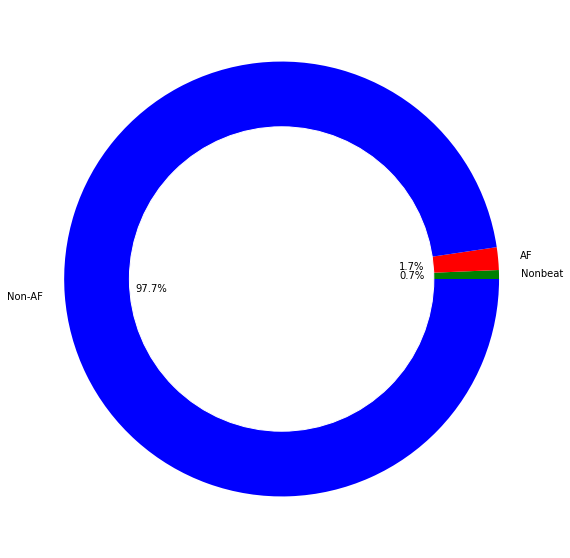

In [21]:
plt.figure(figsize=(20,10))
myCircle = plt.Circle((0,0),0.7,color='white')
plt.pie(gf, labels = ['Nonbeat', 'AF', 'Non-AF'], colors=['green','red', 'blue'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(myCircle)
plt.show()

In [1]:
# Function that loads a patient's signls and annotations
def load_ecg(file):
    record = wfdb.rdrecord(file)
    annotation = wfdb.rdann(file, 'atr')
    
    p_signal = record.p_signal
    
    ann_sym = annotation.symbol
    ann_sample = annotation.sample
    
    return p_signal, ann_sym, ann_sample

In [14]:
file = dataPath + pIds[1]

In [15]:
p_signal, atr_sym, atr_sample = load_ecg(file)

In [16]:
values, counts = np.unique(atr_sym, return_counts=True)
for v,c in zip(values, counts):
    print(v, c)

" 1
+ 1866
A 14590
N 92785
V 863


In [17]:
#get AF beat index 
af_index = [b for a, b in zip(atr_sym, atr_sample) if a == 'A'][:10]
af_index

[28812, 29841, 30839, 31611, 32388, 36300, 43491, 44135, 45836, 46585]

In [19]:
x = np.arange(len(p_signal))

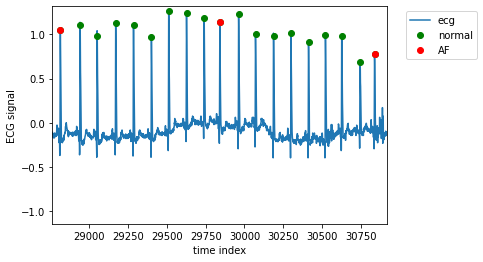

In [20]:
left = af_index[1]-1080
right = af_index[1]+1080

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[af_index],p_signal[af_index,0],'ro',label='AF')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()